In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Added new tools of my own

In [3]:
from langchain_openai import ChatOpenAI
import math

def add(a: int, b: int) -> int:
    """Add two integers.

    Args:
        a: First integer
        b: Second integer

    Returns:
        Sum of a and b
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: First integer
        b: Second integer

    Returns:
        Result of a - b
    """
    return a - b

def multiply(a: int, b: int) -> int:
    """Multiply two integers.

    Args:
        a: First integer
        b: Second integer

    Returns:
        Product of a and b
    """
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: Dividend
        b: Divisor

    Returns:
        Result of a / b
    """
    return a / b

def exponent(a: int, b: int) -> int:
    """Raise a to the power of b.

    Args:
        a: Base integer
        b: Exponent integer

    Returns:
        a raised to the power b
    """
    return a ** b

def factorial(n: int) -> int:
    """Calculate factorial of n.

    Args:
        n: An integer (should be >= 0)

    Returns:
        Factorial of n
    """
    return math.factorial(n)

def modulus(a: int, b: int) -> int:
    """Compute a modulo b.

    Args:
        a: Dividend
        b: Divisor

    Returns:
        Remainder after dividing a by b
    """
    return a % b

def integer_division(a: int, b: int) -> int:
    """Integer division (floor division) of a by b.

    Args:
        a: Dividend
        b: Divisor

    Returns:
        Quotient of a // b
    """
    return a // b

tools = [
    add,
    subtract,
    multiply,
    divide,
    exponent,
    factorial,
    modulus,
    integer_division
]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


## defined the graph

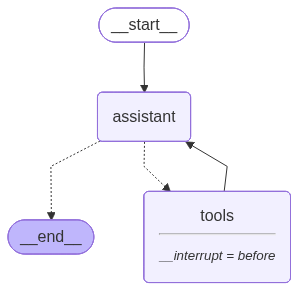

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## tried multiple examples of my own

In [5]:
# Input
initial_input = {"messages": HumanMessage(content="raise 5 to the power of 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

raise 5 to the power of 3
================================== Ai Message ==================================
Tool Calls:
  exponent (call_ssQAyn7BfgFwXfa9Thu3LmaD)
 Call ID: call_ssQAyn7BfgFwXfa9Thu3LmaD
  Args:
    a: 5
    b: 3


In [6]:
state = graph.get_state(thread)
state.next
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  exponent (call_ssQAyn7BfgFwXfa9Thu3LmaD)
 Call ID: call_ssQAyn7BfgFwXfa9Thu3LmaD
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: exponent

125
================================== Ai Message ==================================

5 raised to the power of 3 is 125.


In [7]:
# Input
initial_input = {"messages": HumanMessage(content="integer divide 20 by 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

integer divide 20 by 3
================================== Ai Message ==================================
Tool Calls:
  integer_division (call_FExQn4H7u7ApT1dSaUj1StiB)
 Call ID: call_FExQn4H7u7ApT1dSaUj1StiB
  Args:
    a: 20
    b: 3


In [8]:
state = graph.get_state(thread)
state.next
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  integer_division (call_FExQn4H7u7ApT1dSaUj1StiB)
 Call ID: call_FExQn4H7u7ApT1dSaUj1StiB
  Args:
    a: 20
    b: 3
================================= Tool Message =================================
Name: integer_division

6
================================== Ai Message ==================================

The result of the integer division of 20 by 3 is 6.


## made a chatbot, which only calls the tool if it gets the magic word (please)

In [9]:



print("To proceed, you must speak the magic word! ✨")
user_approval = input("What is the magic word? (Hint: it's 'please'): ")

# Check for approval with the magic word or any creative synonyms
if user_approval.strip().lower() in ["please", "abracadabra"]:
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event["messages"][-1].pretty_print()
    print("✨ The magic worked! Tool executed.")
else:
    print("Oops! You didn't say the magic word. Operation canceled by user.")


To proceed, you must speak the magic word! ✨
================================== Ai Message ==================================

The result of the integer division of 20 by 3 is 6.
✨ The magic worked! Tool executed.


## made a chatbot which asks us for permission before answering and it is case insensitive

In [10]:


user_approval = input("Do you want to call the tool? (yes/no): ")

if user_approval.strip().lower() == "yes":
    for event in graph.stream(None, thread, stream_mode="values"):
        event["messages"][-1].pretty_print()
else:
    print("Operation cancelled by user.")


================================== Ai Message ==================================

The result of the integer division of 20 by 3 is 6.


## IN LANGGRAPH API

In [11]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

## added the interrupt after so that it will ask permission whenever we have repeated function calls as in this example

In [12]:
initial_input = {"messages": HumanMessage(content="multiply 2 and 6 and then divide it by 4")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_after=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'multiply 2 and 6 and then divide it by 4', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '5f537c01-5fc8-4d55-aed5-761b43b1a2ed'}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 50, 'prompt_tokens': 210, 'total_tokens': 260, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVG21cEXitnJDjKQ3xplQd6ApT0lm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, '

In [13]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_after=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '3.0', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'divide', 'id': '5c4d851f-f2dc-452e-8399-68a8c6eeffcc', 'tool_call_id': 'call_M5Ffyt9y6uhFnrFwD4eba61D', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The result of multiplying 2 and 6 is 12. When you divide 12 by 4, you get 3.0.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 30, 'prompt_tokens': 278, 'total_tokens': 308, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8

## we can see that the interrupt is after the tools node in the lamggraph studio: 
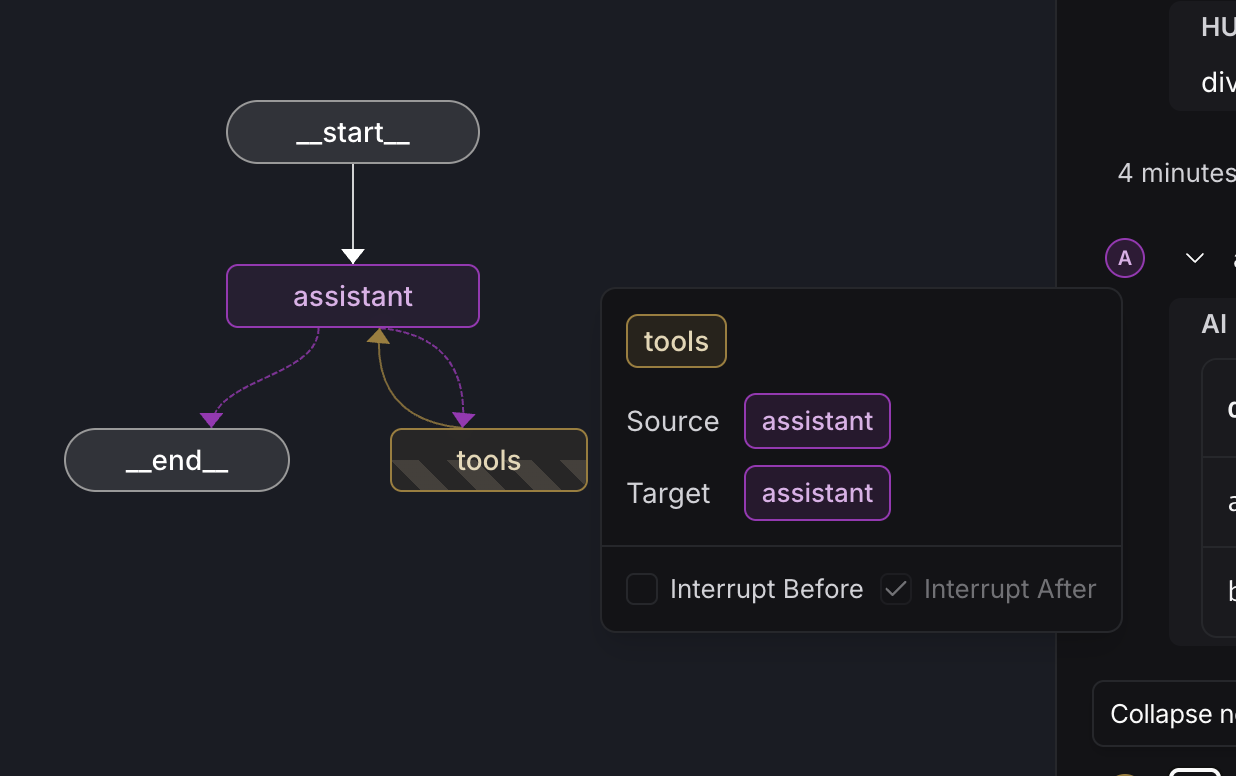

## we can also see this in this example : 

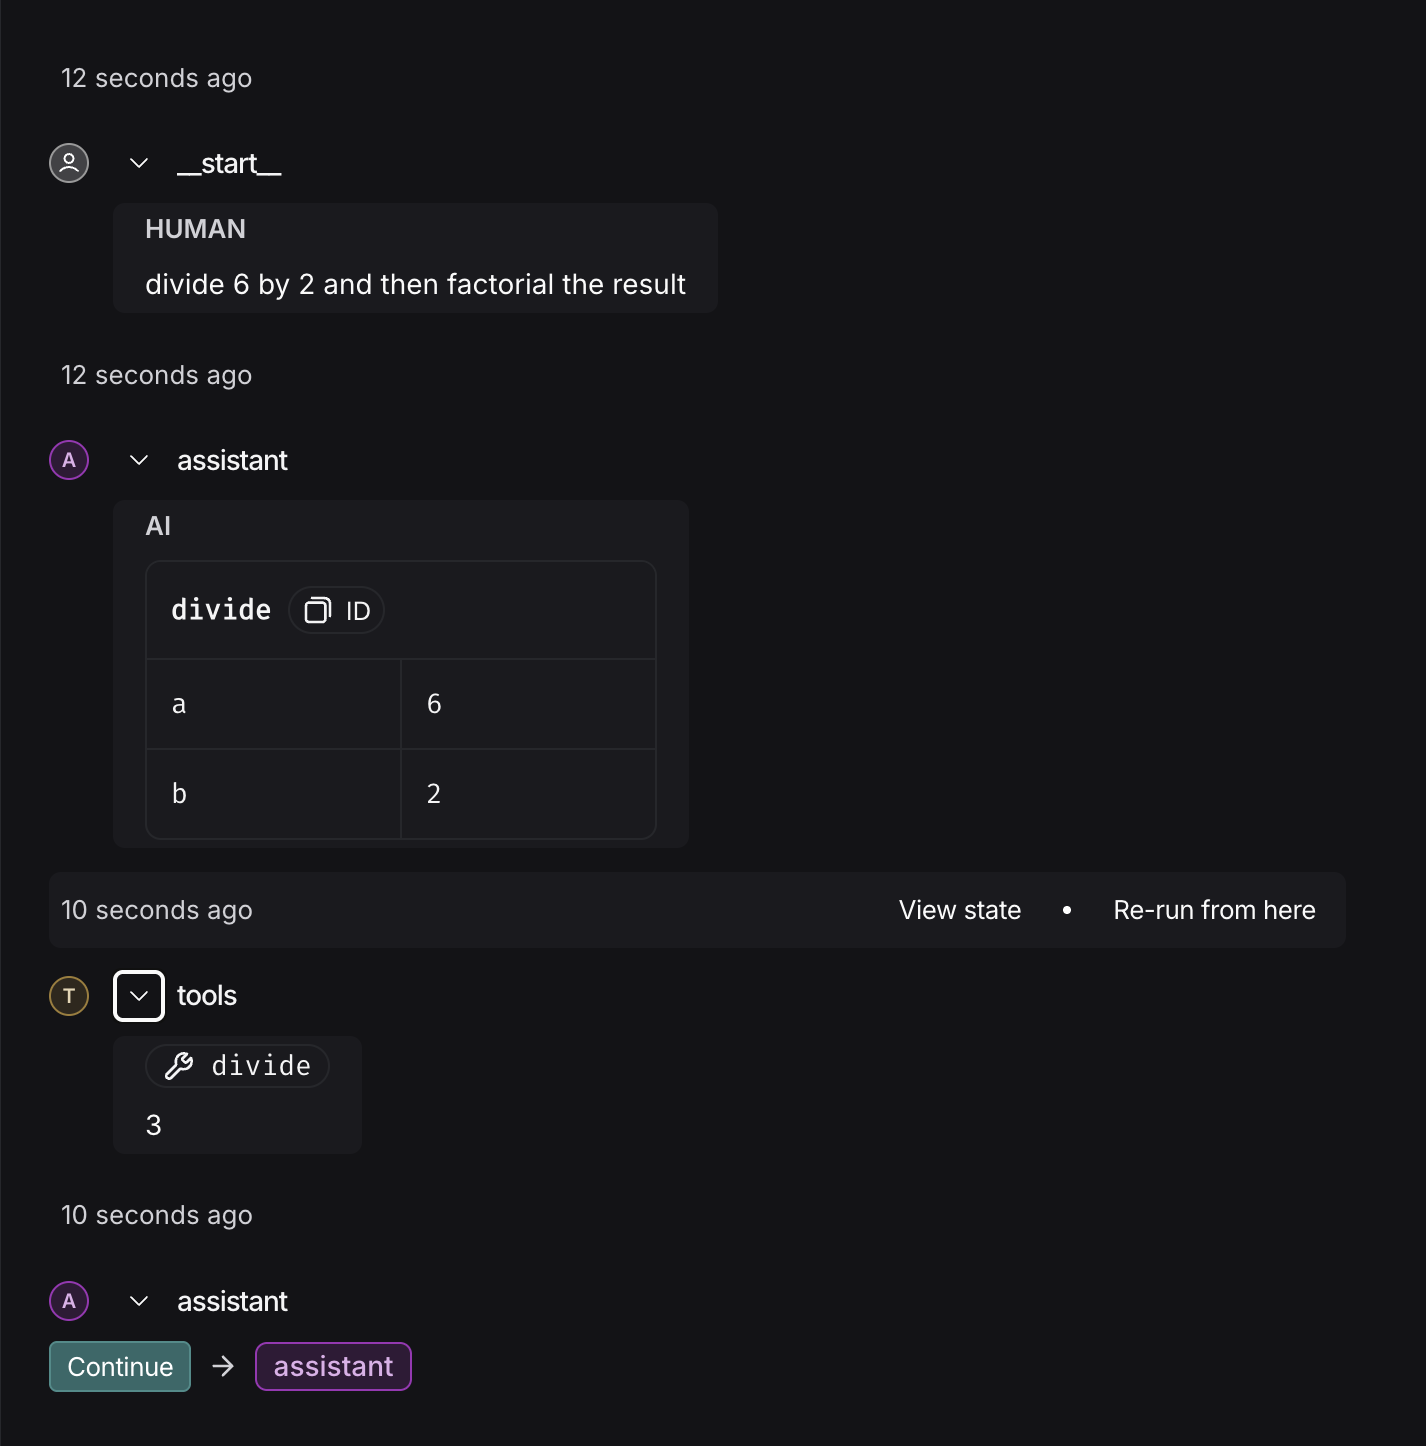

### (after i hit contnue):
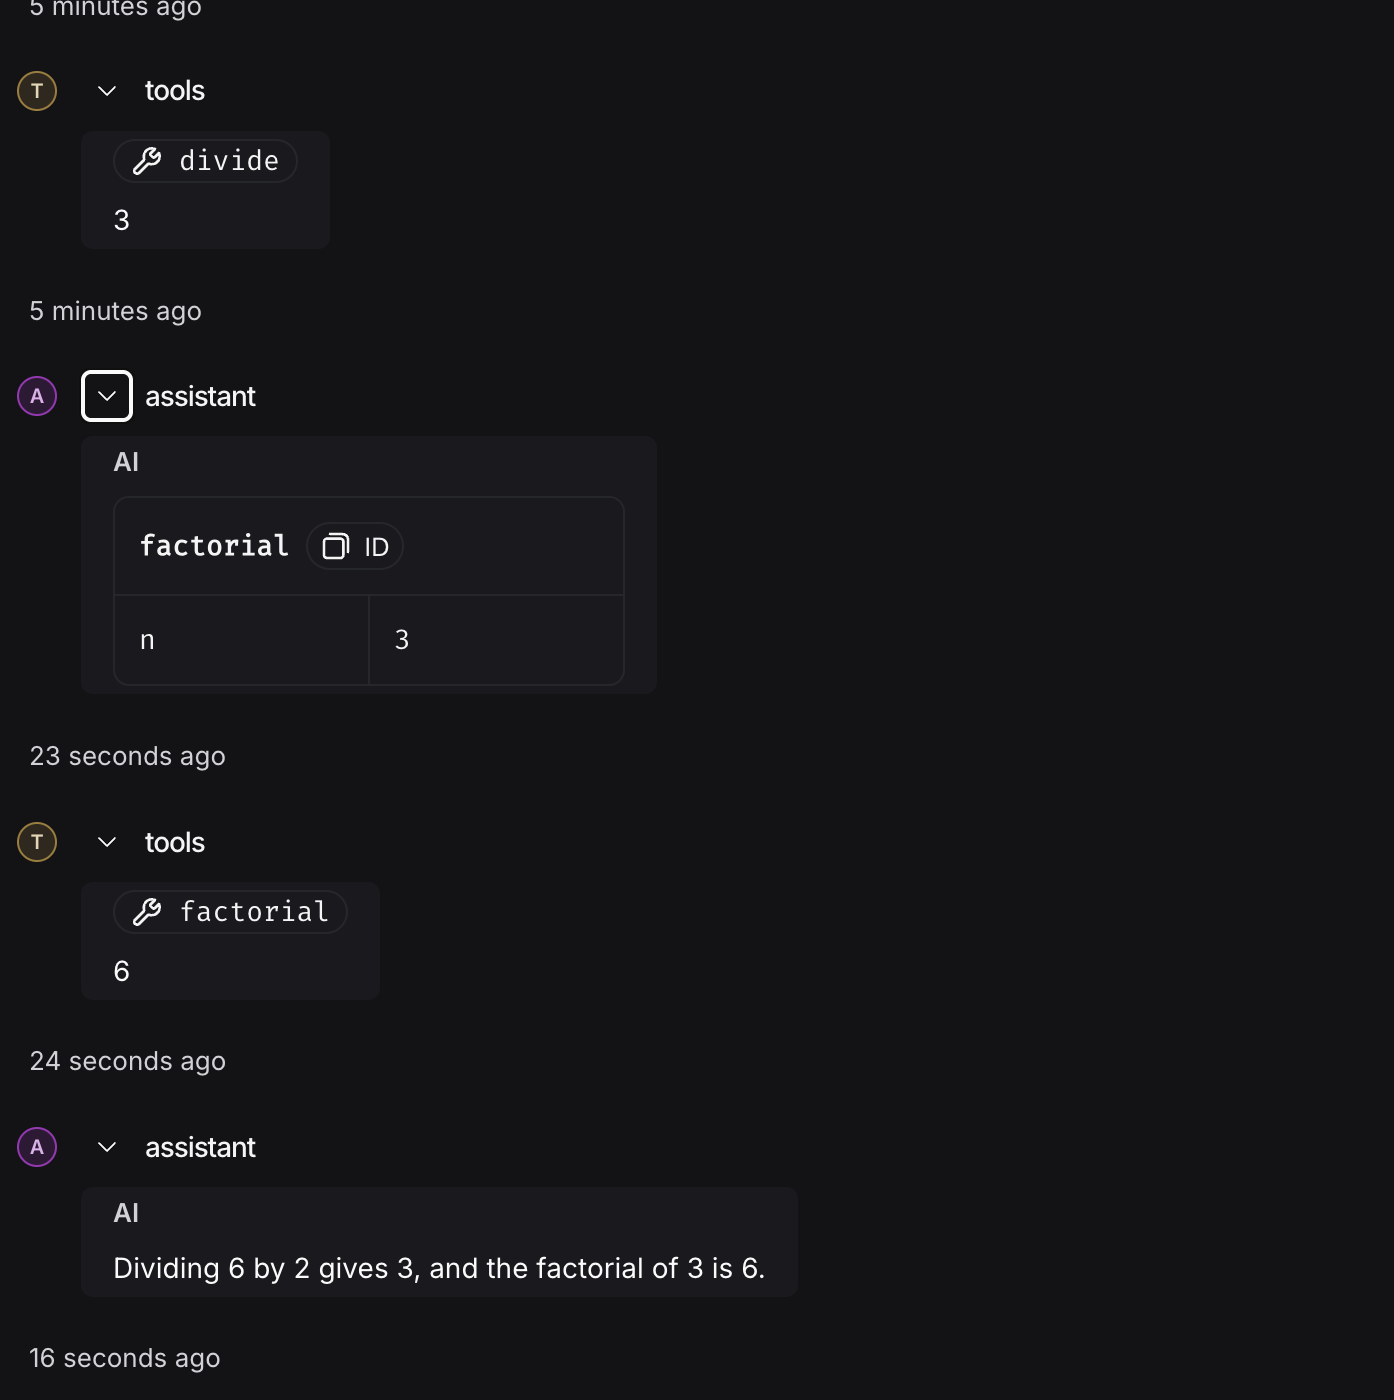

## here we have passed the interrupt_before directly as a parameter through the api

In [14]:
initial_input = {"messages": HumanMessage(content=" Factorial of 6")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': ' Factorial of 6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '2cb9c548-233f-4e38-af69-424e8d464404'}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 14, 'prompt_tokens': 202, 'total_tokens': 216, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVG25gfu4oErpQLwbxpqBBn429IsC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None

In [15]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 14, 'prompt_tokens': 202, 'total_tokens': 216, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVG25gfu4oErpQLwbxpqBBn429IsC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--e09f0f2d-02cc-40ae-a20a-9bb54f7d09b4-0', 'tool_calls': [{'name': 'factorial', 'args': {'n': 6}, 'id': 'call_mfIsef7uDK9DfoVc3ohjnlUD', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 202, 'output

### we can see in the langgraph studio that the breakpoint was added before :  
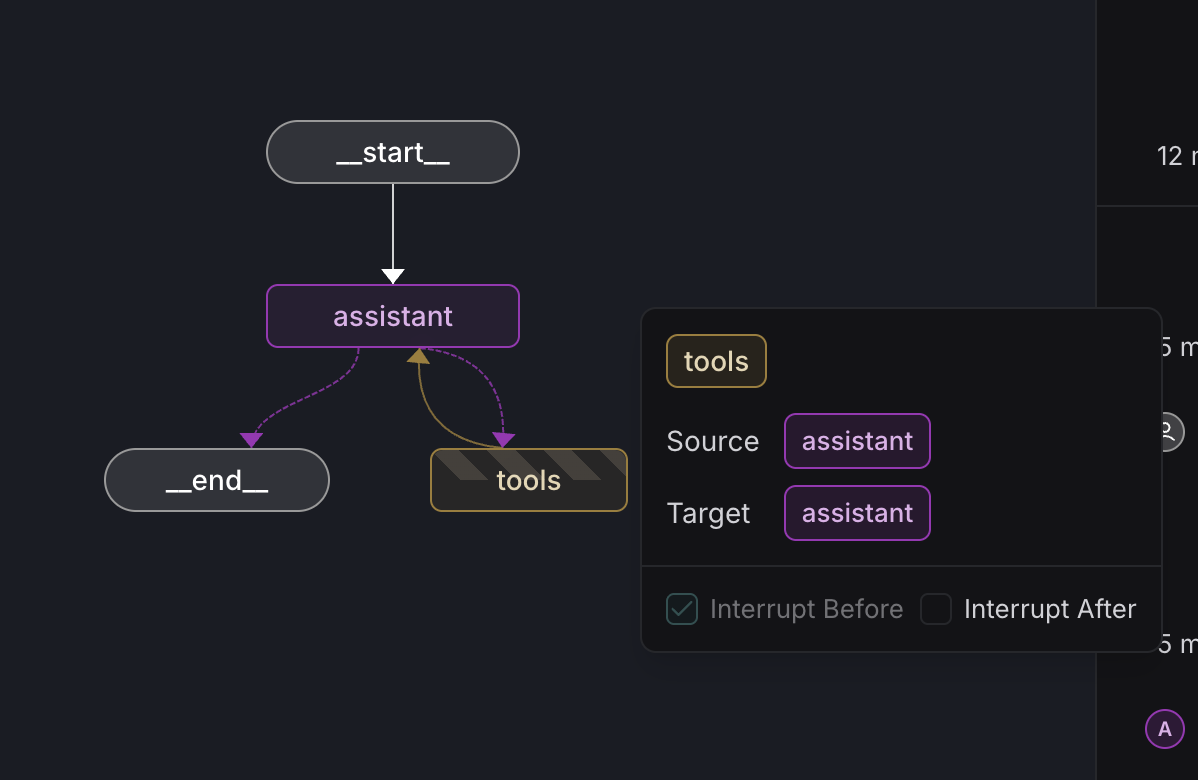

### the llm askes for permission before continuing :
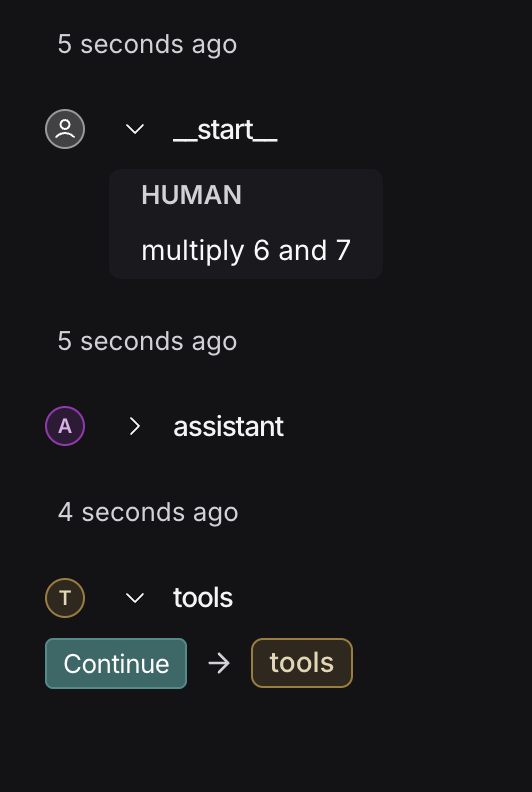